In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [62]:
res_prefix = 'mcmc_test' # t1 -- > Normal results with corrections, t0 before corrections

#### Some functions

In [63]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [76]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e16, Ncol[1], 1.e25]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.e-7

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, Xconv = 1.e-7, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=1.e-7))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=1.e-7))

            
    # Get theoretical errors
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=1.e-7, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=1.e-7, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])

    print(Tb7_thr_err)

    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print(Tb6_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit')
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    ax.errorbar(tb7, tb6, xerr = np.sqrt((0.1*tb7)**2 + 1.08**2), 
                yerr = np.sqrt((0.1*tb6)**2 + 0.49**2),  
                color = 'red', marker = 'o', ms=5, label = 'Observed')
    
    #ax.set_ylim(0,20)
    #ax.set_xlim(0,20)

    plt.grid()

    
    plt.legend(prop={'size': 6})


    Tb_6_pred, Tb_6_err = Tb_6_pred[4], [Tb_6_pred[2]-Tb_6_pred[4], Tb_6_pred[6]-Tb_6_pred[4]]
    Tb_7_pred, Tb_7_err = Tb_7_pred[4], [Tb_7_pred[2]-Tb_7_pred[4], Tb_7_pred[6]-Tb_7_pred[4]]

    return fig, ax, (Tb_6_pred, Tb_6_err) , (Tb_7_pred, Tb_7_err)

#### Generate the Data

In [77]:


np.random.seed(41)
lg_N = np.abs(np.random.normal(loc =  22, scale = 2.5, size = 15))
Texe = np.abs(np.random.normal(loc =  20, scale = 10., size = 15))

# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')


Tb7 = []
Tb7_with_rand_error = []
Tb7_with_rand_error_nobnd = []
Tb6 = []
Tb6_with_rand_error = []
Tb6_with_rand_error_nobnd = []

for lg_n,texe in zip(lg_N,Texe):

    Tb7.append(lte_model.get_intensity(line = 'c18o', Ju = 3, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))
    Tb6.append(lte_model.get_intensity(line = 'c18o', Ju = 2, Ncol = 10**lg_n, Tex = texe, delv = 7417.8, Xconv=1.e-7))

    Tb7_with_rand_error.append(np.abs(np.random.normal(loc=Tb7[-1], scale=np.sqrt(1.08**2 + (0.1*Tb7[-1])**2))))
    Tb6_with_rand_error.append(np.abs(np.random.normal(loc=Tb6[-1], scale=np.sqrt(0.49**2 + (0.1*Tb6[-1])**2))))

    Tb7_with_rand_error_nobnd.append(np.abs(np.random.normal(loc=Tb7[-1], scale=abs(0.9*Tb7[-1]))))
    Tb6_with_rand_error_nobnd.append(np.abs(np.random.normal(loc=Tb6[-1], scale=abs(0.9*Tb6[-1]))))

#### Data visualization (data without noise)

lg_N [21.32, 22.26, 22.63, 19.69, 23.42, 19.4, 21.62, 23.97, 18.93, 19.63, 20.58, 19.56, 20.07, 21.92, 19.42]
lg T [31.42, 13.9, 34.69, 34.93, 27.07, 1.42, 6.29, 16.7, 4.85, 32.0, 1.77, 22.69, 15.54, 31.14, 6.19]


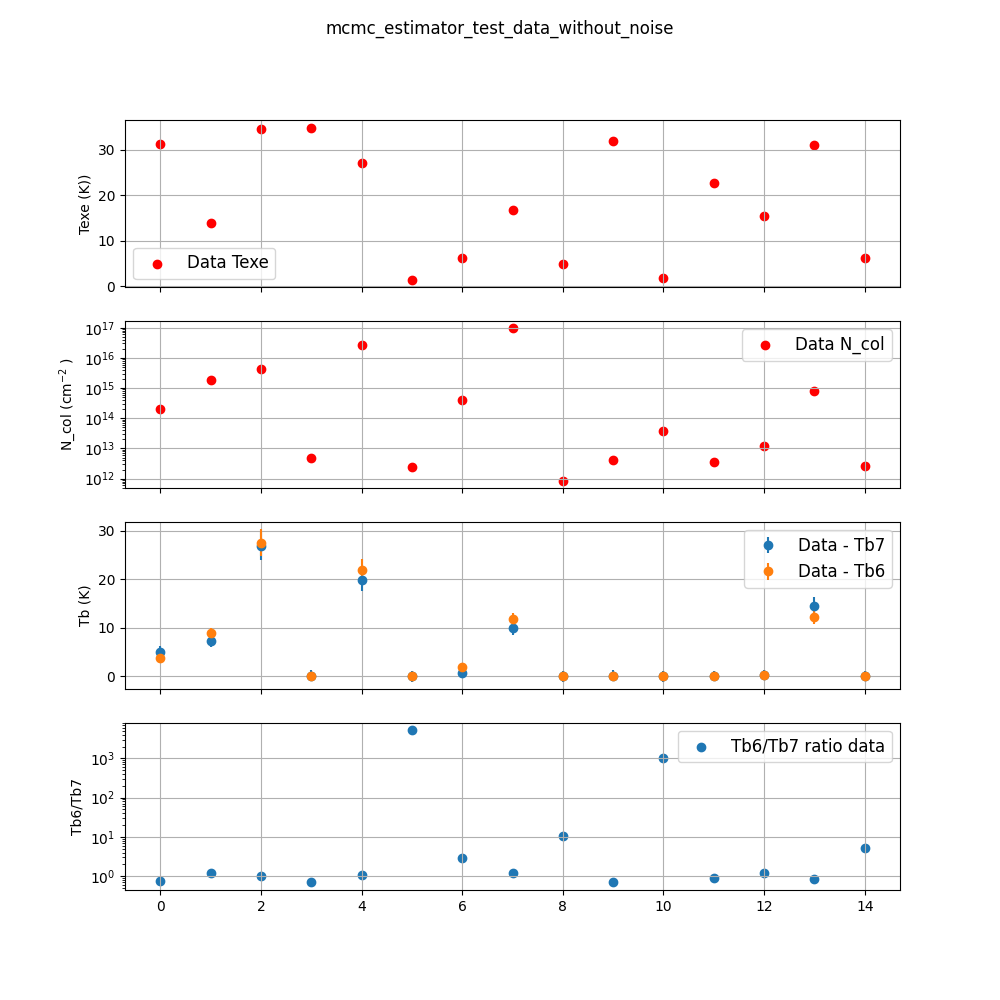

In [78]:
op_dir_label = "mcmc_estimator_test_data_without_noise"
print("lg_N",[round(n,2) for n in lg_N])
print("lg T",[round(t,2) for t in Texe])


vis_data_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

N_conv_fraction = 1.e-7
r = np.arange(len(Tb7))


axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Data N_col')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[0].scatter(r, Texe, marker='o', color = 'r', label = 'Data Texe')
axes[0].set_ylabel(r"Texe (K))")
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[2].errorbar(r, Tb7, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7', fmt='o')
axes[2].errorbar(r, Tb6, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6', fmt='o')
axes[2].set_ylabel(r"Tb (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})

axes[3].scatter(r, np.array(Tb6)/np.array(Tb7), marker='o', label = 'Tb6/Tb7 ratio data')
axes[3].set_ylabel(r"Tb6/Tb7")
axes[3].set_yscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 12})


vis_data_fig.suptitle(op_dir_label)

vis_results_figname =  'mcmc_test_data_without_noise.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_data_figpath = os.path.join(dir_path, vis_results_figname)
vis_data_fig.savefig(fname = vis_data_figpath, dpi=300, format='jpeg')



#### T estimation loop (data without noise)

In [79]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for i = 0 , Tb7 = 5.1, Tb6 = 3.9


100%|██████████| 5000/5000 [00:12<00:00, 412.02it/s]


dtauv_dT =  6.320733777044077e-06
dtauv_dT =  2.317237415020462e-06
Tb7_dIv_dN = 2.08e-14, Tb6_dIv_dN = 1.66e-14
Tb7_dIv_dT = 0.23, Tb6_dIv_dT = 0.16
Ncols and lgNcols up 6.36e+22, lgNc = 2.28e+01
Ncols and lgNcols med 2.39e+21, lgNc = 2.14e+01
Ncols and lgNcols dwn 1.92e+21, lgNc = 2.13e+01
del T -> + 19.91, - 22.44
del N -> + 6.12e+22, - 4.68e+20
[[  5.23791454 127.52335308]]
[[  3.72342415 101.40019601]]


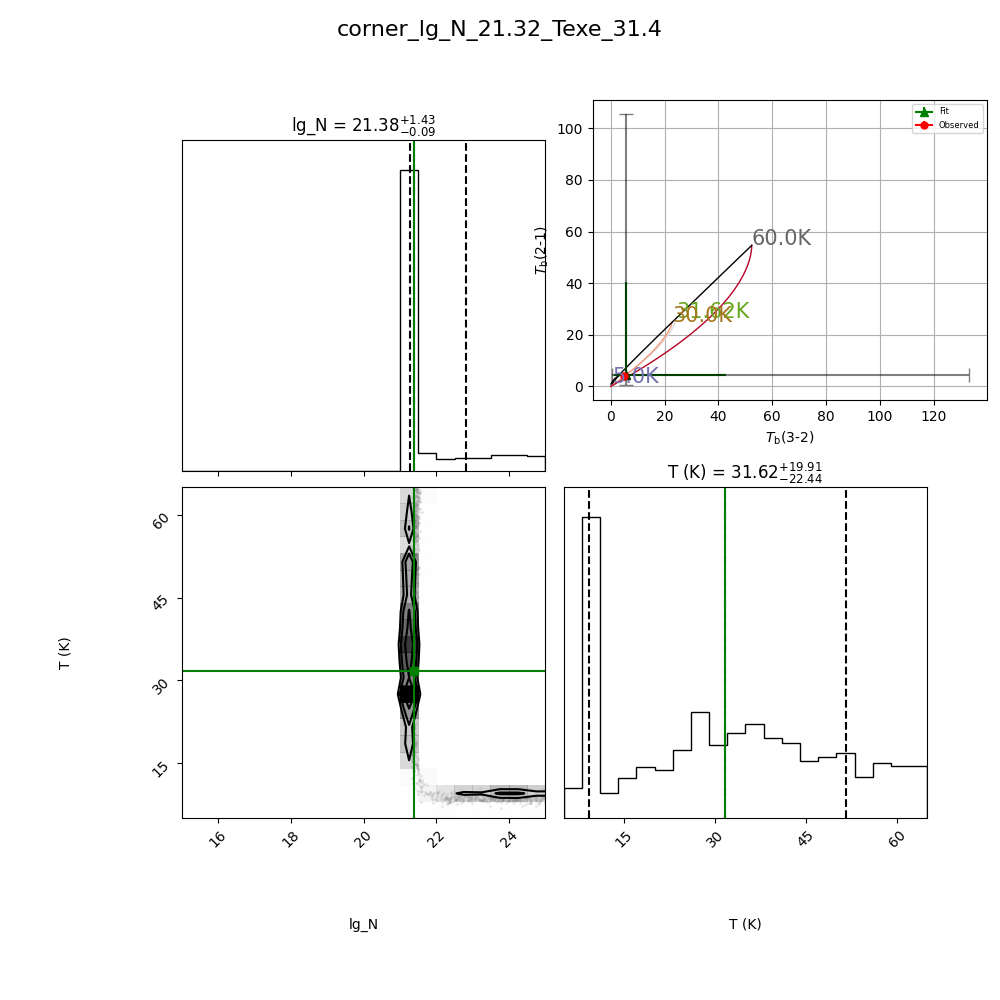

estimating for i = 1 , Tb7 = 7.3, Tb6 = 9.0


100%|██████████| 5000/5000 [00:12<00:00, 401.26it/s]


dtauv_dT =  0.008862866780553976
dtauv_dT =  0.006057222240219119
Tb7_dIv_dN = 6.33e-24, Tb6_dIv_dN = 9.40e-25
Tb7_dIv_dT = 0.90, Tb6_dIv_dT = 0.95
Ncols and lgNcols up 2.29e+24, lgNc = 2.44e+01
Ncols and lgNcols med 9.74e+22, lgNc = 2.30e+01
Ncols and lgNcols dwn 7.00e+21, lgNc = 2.18e+01
del T -> + 3.03, - 0.99
del N -> + 2.19e+24, - 9.04e+22
[[0.8955651  2.72717223]]
[[0.94856112 2.88855556]]


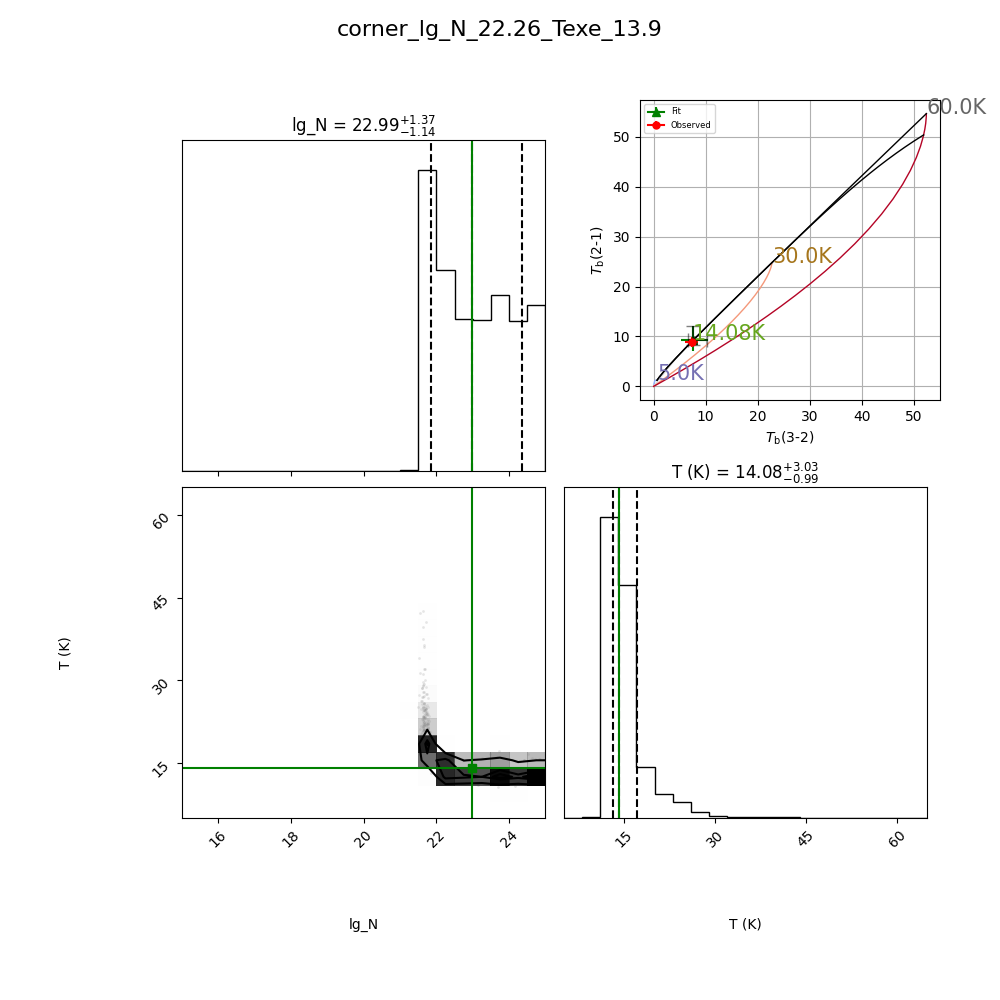

estimating for i = 2 , Tb7 = 26.9, Tb6 = 27.5


100%|██████████| 5000/5000 [00:12<00:00, 400.22it/s]


dtauv_dT =  0.0006285958697952145
dtauv_dT =  0.00022274522806330608
Tb7_dIv_dN = 3.01e-29, Tb6_dIv_dN = 3.34e-24
Tb7_dIv_dT = 0.98, Tb6_dIv_dT = 0.99
Ncols and lgNcols up 3.18e+24, lgNc = 2.45e+01
Ncols and lgNcols med 3.37e+23, lgNc = 2.35e+01
Ncols and lgNcols dwn 4.57e+22, lgNc = 2.27e+01
del T -> + 2.46, - 2.27
del N -> + 2.84e+24, - 2.91e+23
[[2.22748612 2.41927076]]
[[2.24992505 2.44364166]]


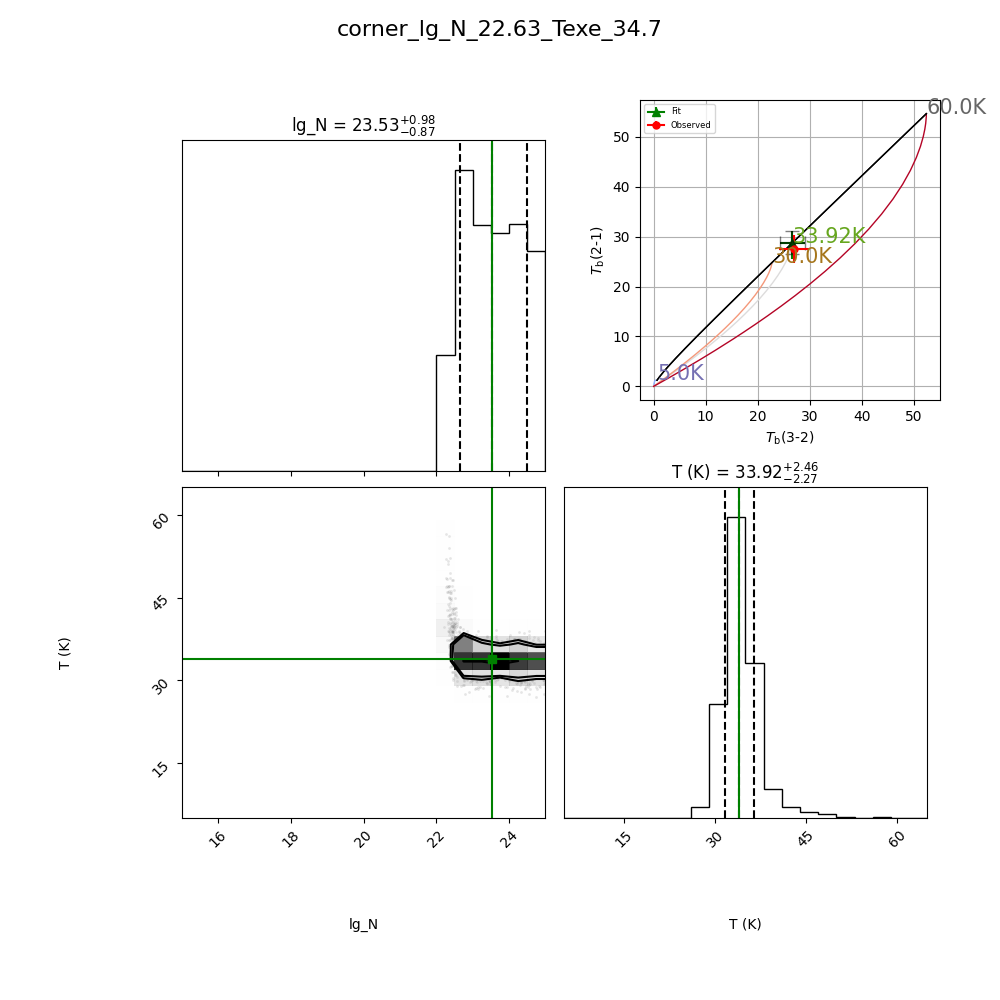

estimating for i = 3 , Tb7 = 0.1, Tb6 = 0.1


100%|██████████| 5000/5000 [00:10<00:00, 476.86it/s]


dtauv_dT =  1.0217324499973705e-09
dtauv_dT =  3.572706838662852e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.89e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 4.67e+19, lgNc = 1.97e+01
Ncols and lgNcols med 6.34e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 7.28e+15, lgNc = 1.59e+01
del T -> + 20.54, - 20.49
del N -> + 4.61e+19, - 6.26e+17
[[0.00211314 0.12509442]]
[[0.00143715 0.08697356]]


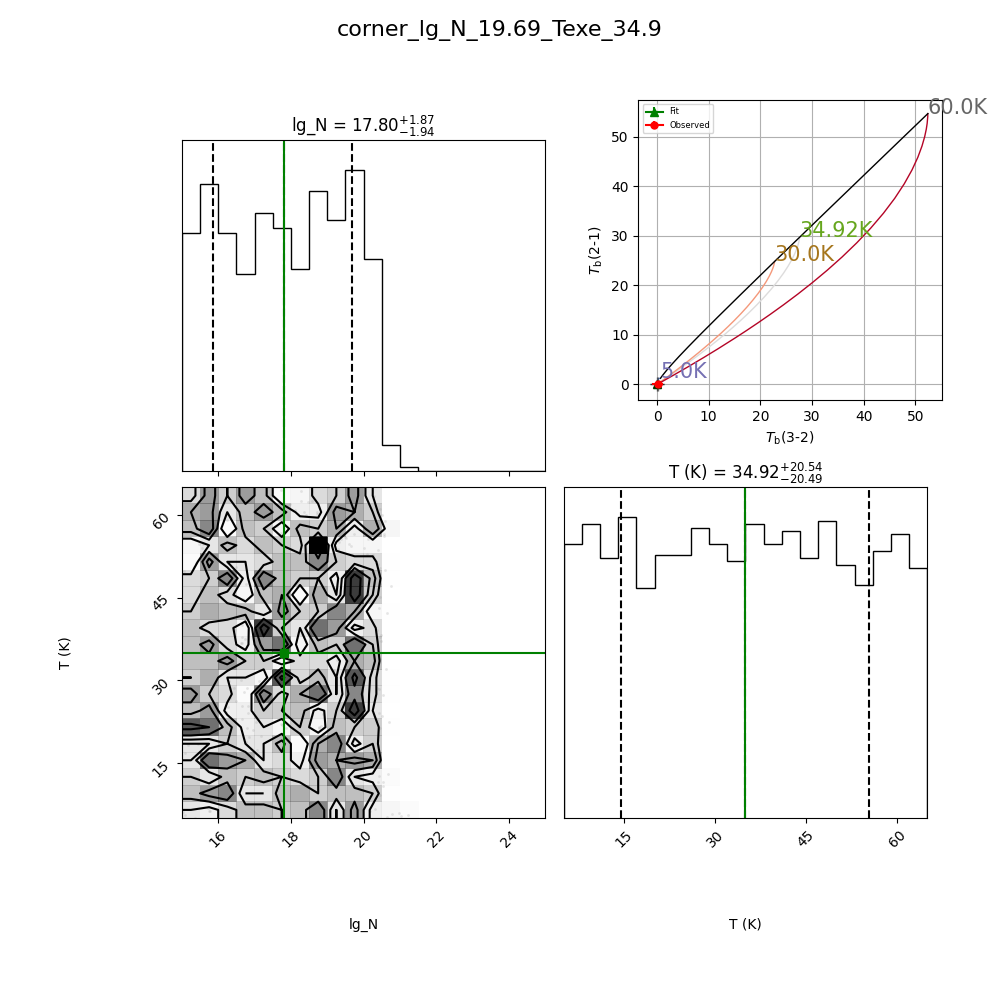

estimating for i = 4 , Tb7 = 19.9, Tb6 = 21.9


100%|██████████| 5000/5000 [00:12<00:00, 404.18it/s]


dtauv_dT =  0.001714053190420842
dtauv_dT =  0.0006802271607693424
Tb7_dIv_dN = 1.40e-32, Tb6_dIv_dN = 1.78e-27
Tb7_dIv_dT = 0.97, Tb6_dIv_dT = 0.99
Ncols and lgNcols up 3.31e+24, lgNc = 2.45e+01
Ncols and lgNcols med 3.16e+23, lgNc = 2.35e+01
Ncols and lgNcols dwn 3.84e+22, lgNc = 2.26e+01
del T -> + 1.93, - 1.80
del N -> + 3.00e+24, - 2.78e+23
[[1.74587439 1.88126242]]
[[1.77308828 1.91058669]]


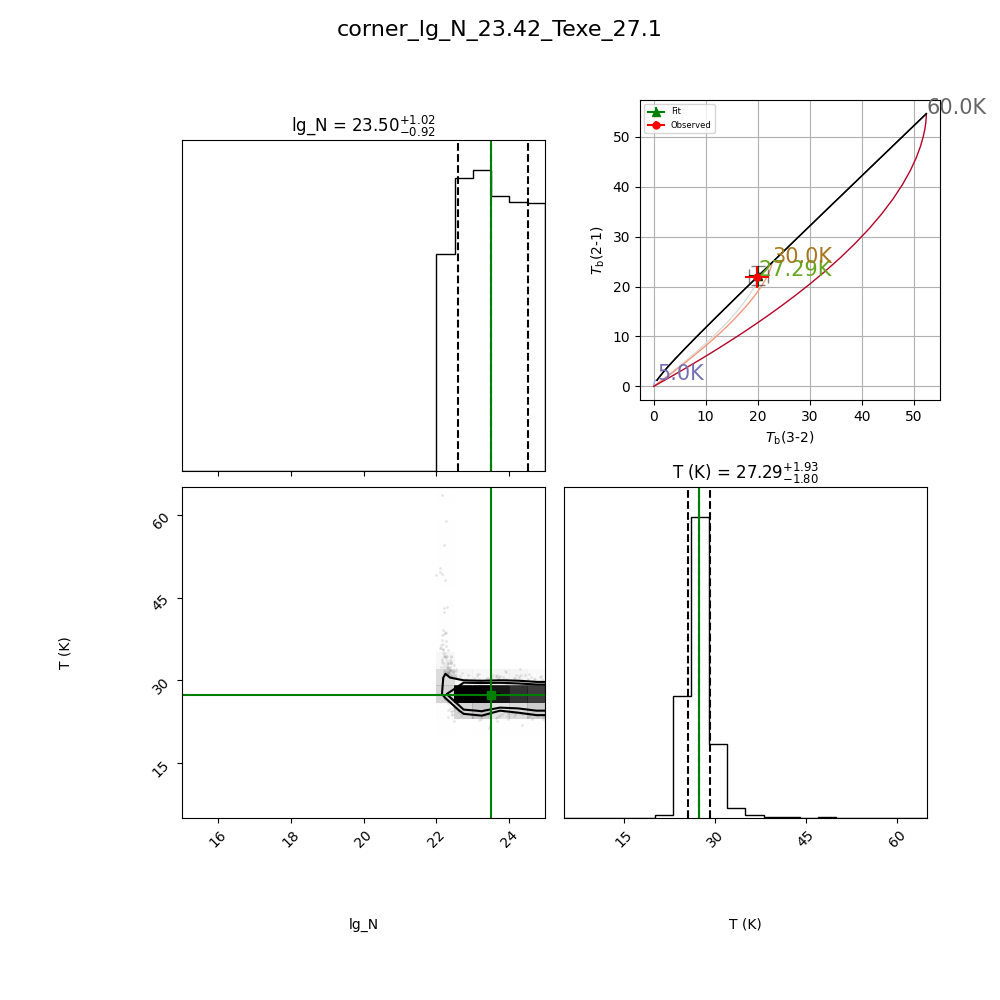

estimating for i = 5 , Tb7 = -0.0, Tb6 = -0.0


100%|██████████| 5000/5000 [00:10<00:00, 459.54it/s]


dtauv_dT =  8.049049308766067e-10
dtauv_dT =  2.870170446112866e-10
Tb7_dIv_dN = 2.72e-14, Tb6_dIv_dN = 1.93e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.47e+19, lgNc = 1.95e+01
Ncols and lgNcols med 4.03e+17, lgNc = 1.76e+01
Ncols and lgNcols dwn 7.83e+15, lgNc = 1.59e+01
del T -> + 21.95, - 19.58
del N -> + 3.43e+19, - 3.96e+17
[[0.00134425 0.09324905]]
[[0.00093086 0.06609483]]


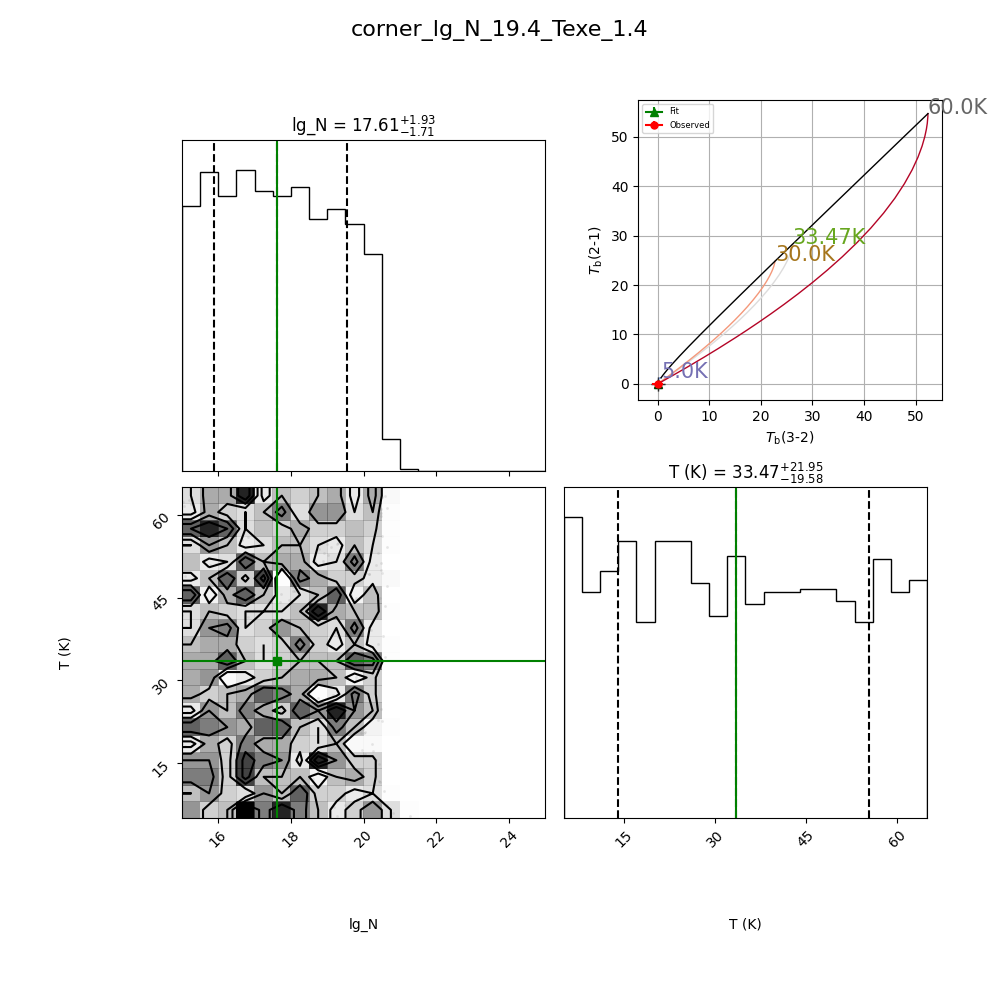

estimating for i = 6 , Tb7 = 0.6, Tb6 = 1.9


100%|██████████| 5000/5000 [00:10<00:00, 463.56it/s]


dtauv_dT =  0.000296558154223788
dtauv_dT =  0.0003055017554795949
Tb7_dIv_dN = 7.50e-15, Tb6_dIv_dN = 1.30e-14
Tb7_dIv_dT = 0.20, Tb6_dIv_dT = 0.31
Ncols and lgNcols up 3.98e+23, lgNc = 2.36e+01
Ncols and lgNcols med 1.20e+21, lgNc = 2.11e+01
Ncols and lgNcols dwn 5.83e+20, lgNc = 2.08e+01
del T -> + 27.01, - 4.53
del N -> + 3.96e+23, - 6.15e+20
[[  1.01353738 297.2546942 ]]
[[  1.63021658 517.17237898]]


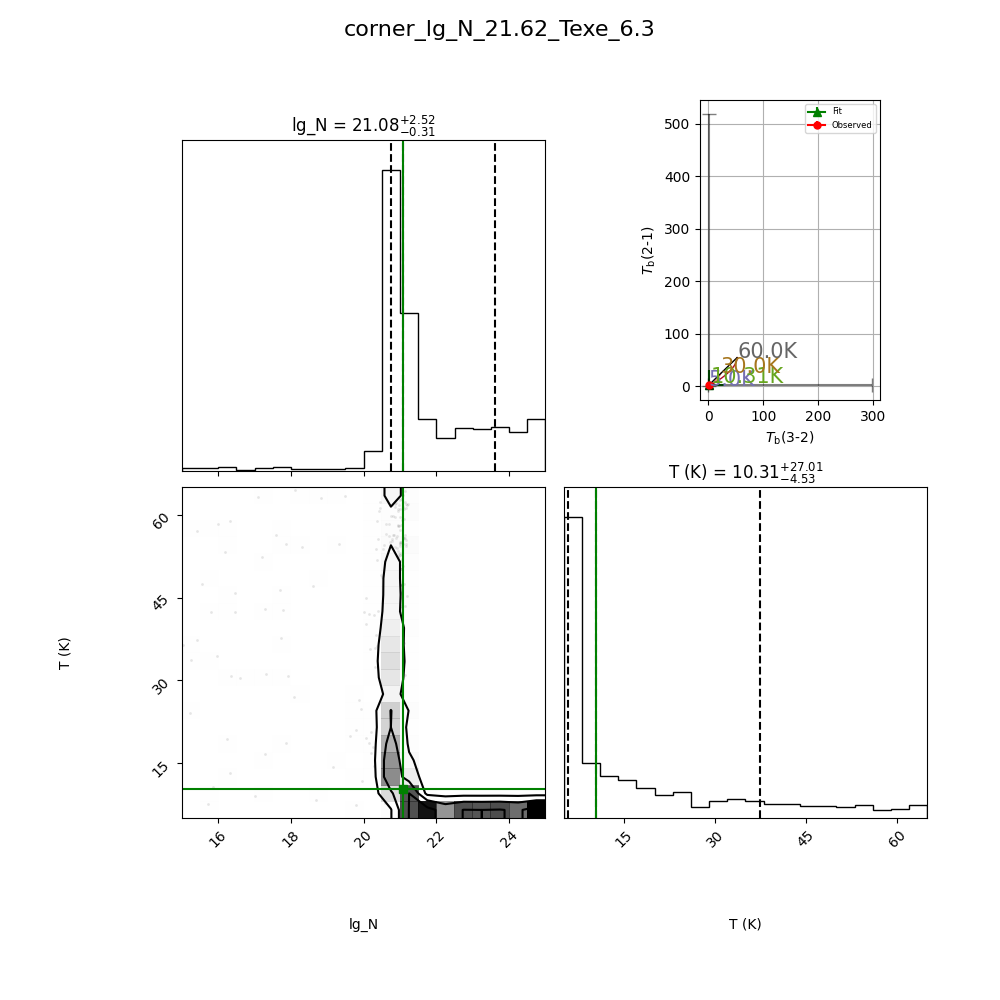

estimating for i = 7 , Tb7 = 10.0, Tb6 = 11.8


100%|██████████| 5000/5000 [00:12<00:00, 397.15it/s]


dtauv_dT =  0.007584693736868349
dtauv_dT =  0.004291656236645541
Tb7_dIv_dN = 2.50e-29, Tb6_dIv_dN = 1.59e-28
Tb7_dIv_dT = 0.93, Tb6_dIv_dT = 0.97
Ncols and lgNcols up 2.94e+24, lgNc = 2.45e+01
Ncols and lgNcols med 1.69e+23, lgNc = 2.32e+01
Ncols and lgNcols dwn 1.35e+22, lgNc = 2.21e+01
del T -> + 1.60, - 1.13
del N -> + 2.77e+24, - 1.55e+23
[[1.05062463 1.48401809]]
[[1.09345781 1.5445204 ]]


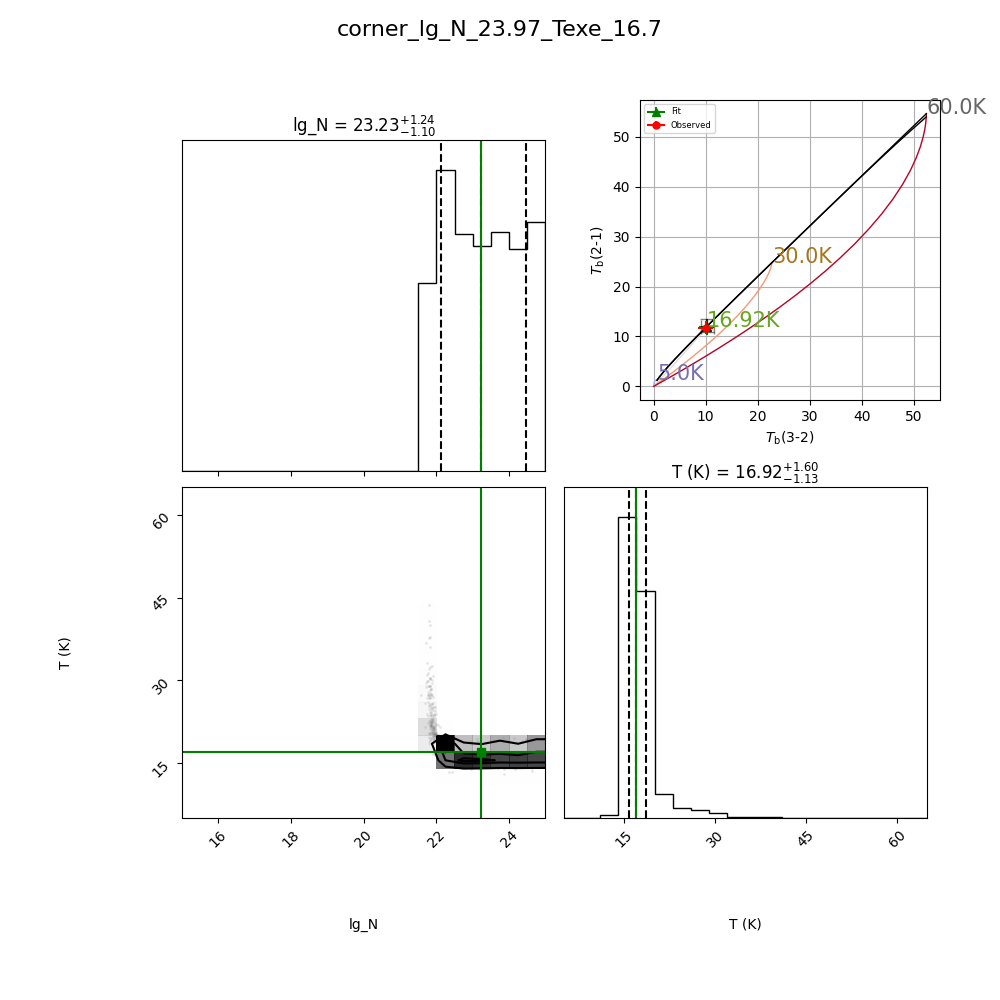

estimating for i = 8 , Tb7 = 0.0, Tb6 = 0.0


100%|██████████| 5000/5000 [00:10<00:00, 465.40it/s]


dtauv_dT =  8.291288723515679e-10
dtauv_dT =  2.890586083558774e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.88e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.94e+19, lgNc = 1.96e+01
Ncols and lgNcols med 5.32e+17, lgNc = 1.77e+01
Ncols and lgNcols dwn 6.51e+15, lgNc = 1.58e+01
del T -> + 20.32, - 20.48
del N -> + 3.88e+19, - 5.25e+17
[[0.00176596 0.10530994]]
[[0.00119793 0.07300287]]


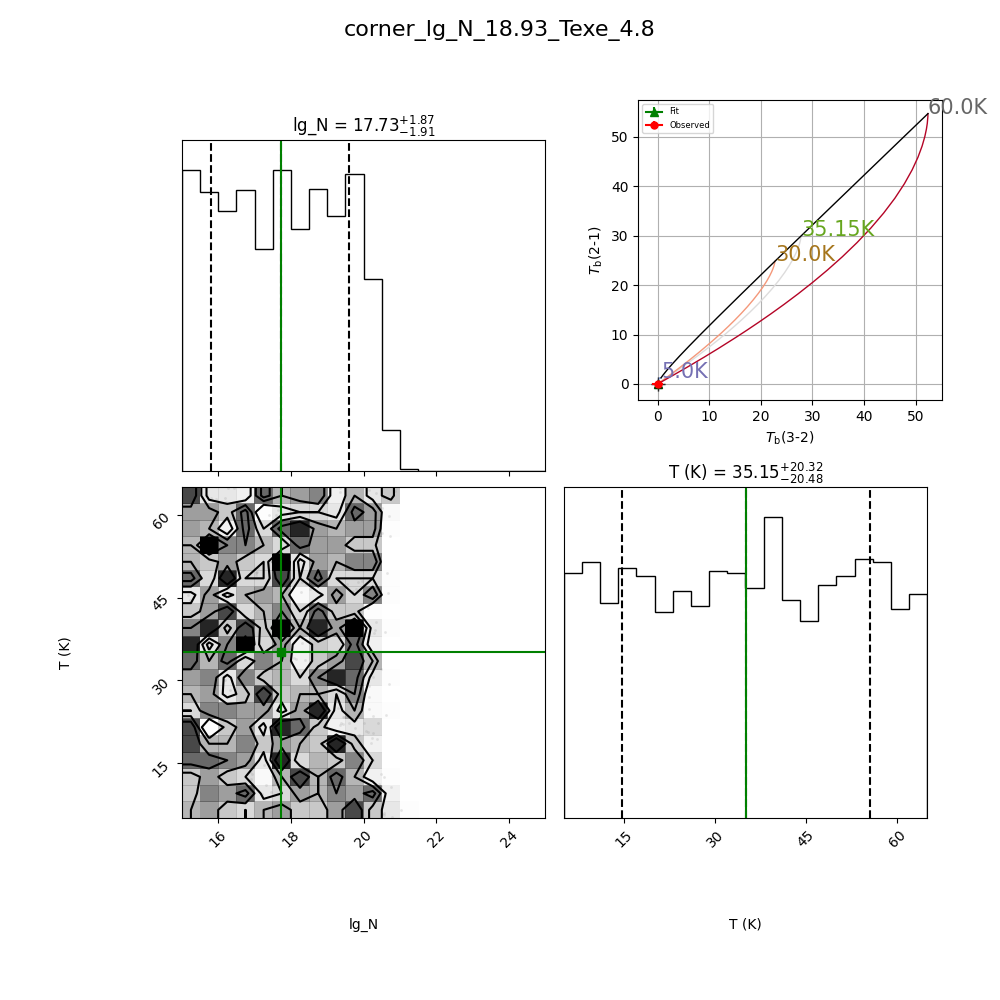

estimating for i = 9 , Tb7 = 0.1, Tb6 = 0.1


100%|██████████| 5000/5000 [00:11<00:00, 452.11it/s]


dtauv_dT =  9.961901030494676e-10
dtauv_dT =  3.4759521073348336e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.88e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 4.62e+19, lgNc = 1.97e+01
Ncols and lgNcols med 6.33e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 7.73e+15, lgNc = 1.59e+01
del T -> + 20.17, - 21.19
del N -> + 4.56e+19, - 6.25e+17
[[0.00212953 0.12364286]]
[[0.00144418 0.08578343]]


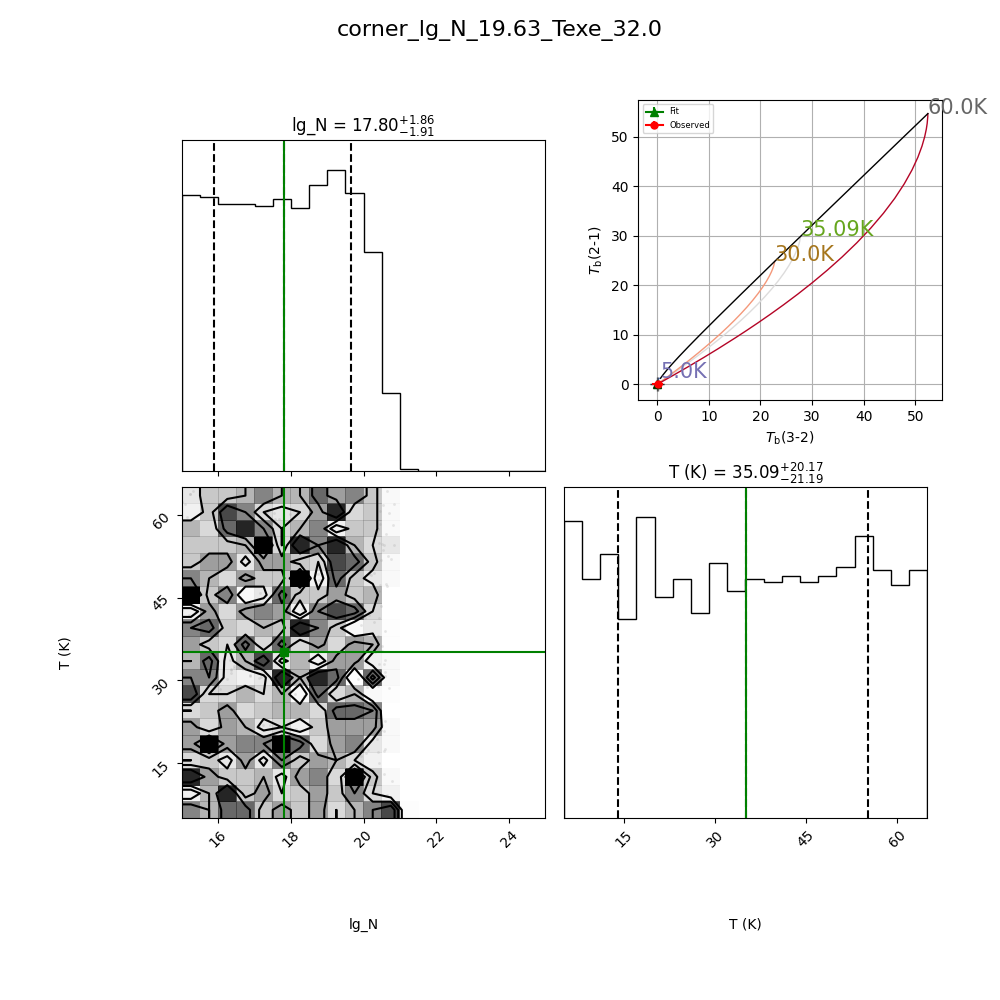

estimating for i = 10 , Tb7 = -0.0, Tb6 = -0.0


100%|██████████| 5000/5000 [00:11<00:00, 433.57it/s]


dtauv_dT =  1.1573040134364704e-09
dtauv_dT =  4.1031138446308804e-10
Tb7_dIv_dN = 2.72e-14, Tb6_dIv_dN = 1.91e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.32e+19, lgNc = 1.95e+01
Ncols and lgNcols med 6.17e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 7.91e+15, lgNc = 1.59e+01
del T -> + 21.63, - 19.80
del N -> + 3.26e+19, - 6.09e+17
[[0.00206058 0.08866517]]
[[0.00141963 0.06249077]]


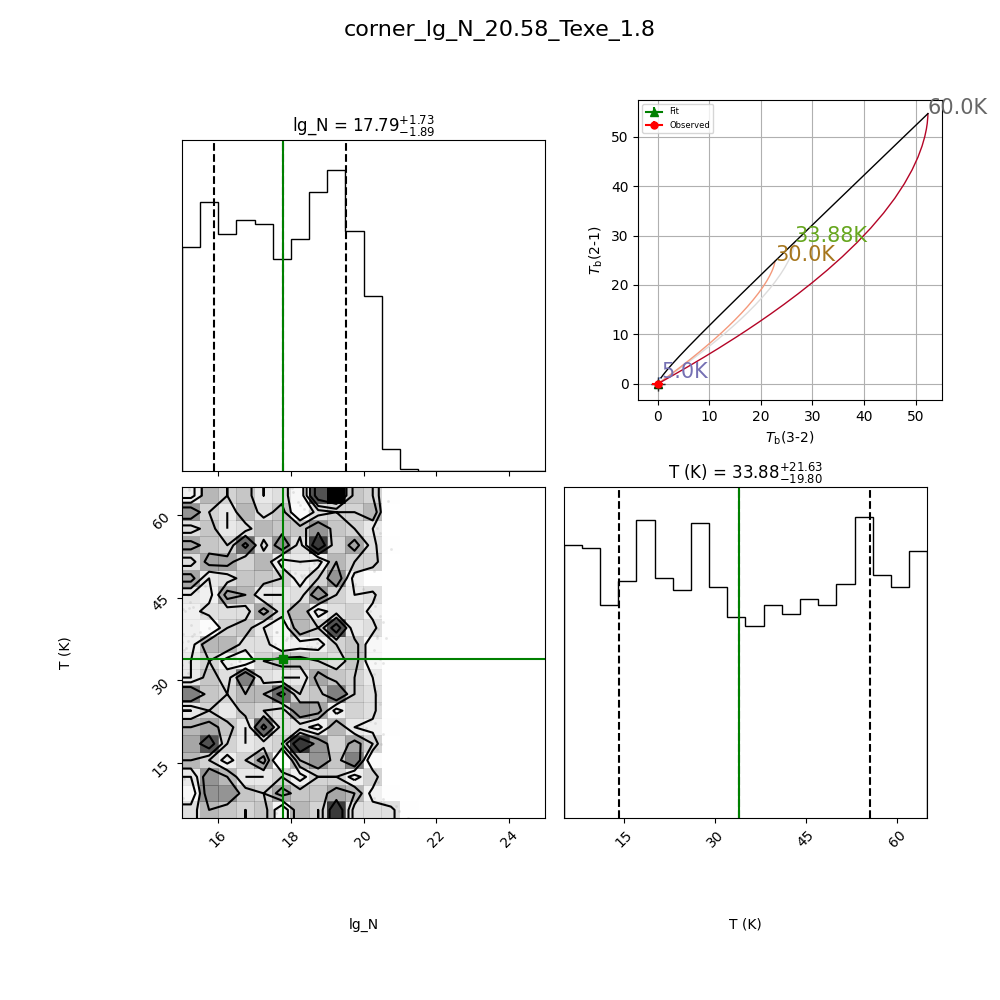

estimating for i = 11 , Tb7 = 0.1, Tb6 = 0.1


100%|██████████| 5000/5000 [00:10<00:00, 467.80it/s]


dtauv_dT =  7.734257699078727e-10
dtauv_dT =  2.6826852192134614e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.87e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 4.42e+19, lgNc = 1.96e+01
Ncols and lgNcols med 5.25e+17, lgNc = 1.77e+01
Ncols and lgNcols dwn 8.21e+15, lgNc = 1.59e+01
del T -> + 20.42, - 21.46
del N -> + 4.37e+19, - 5.17e+17
[[0.00176041 0.11839361]]
[[0.00118719 0.08166181]]


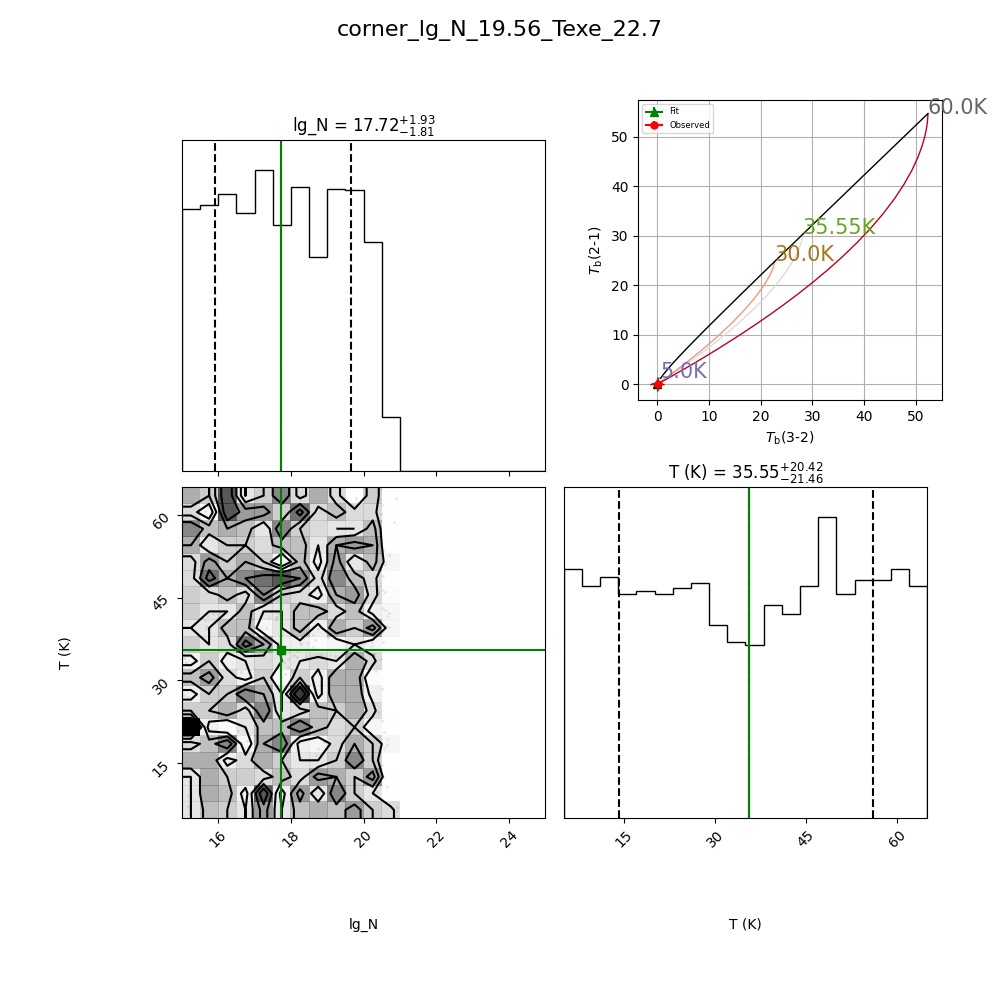

estimating for i = 12 , Tb7 = 0.2, Tb6 = 0.3


100%|██████████| 5000/5000 [00:10<00:00, 477.55it/s]


dtauv_dT =  7.42294451617798e-10
dtauv_dT =  2.5792419360613976e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.87e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 6.53e+19, lgNc = 1.98e+01
Ncols and lgNcols med 4.94e+17, lgNc = 1.77e+01
Ncols and lgNcols dwn 6.50e+15, lgNc = 1.58e+01
del T -> + 19.34, - 22.03
del N -> + 6.48e+19, - 4.88e+17
[[0.0016785 0.1755993]]
[[0.00113287 0.12132991]]


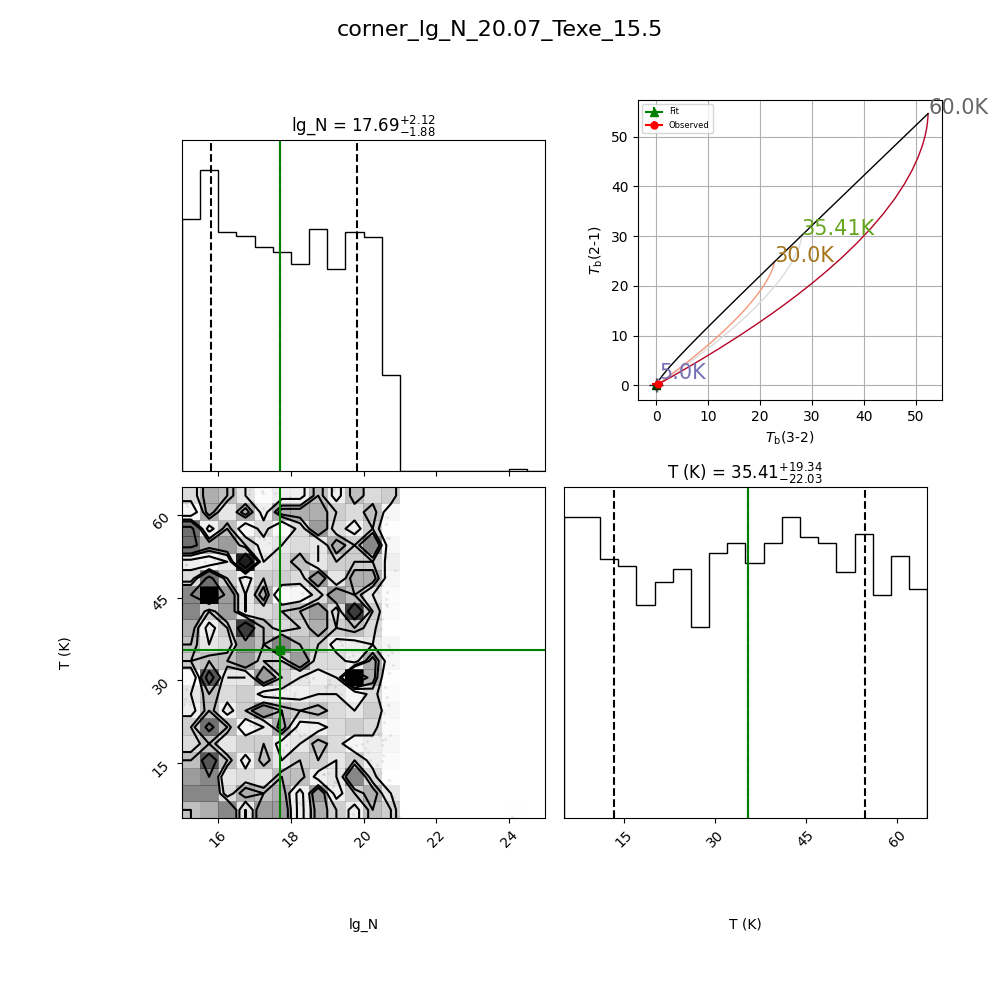

estimating for i = 13 , Tb7 = 14.5, Tb6 = 12.2


100%|██████████| 5000/5000 [00:12<00:00, 413.48it/s]


dtauv_dT =  4.6737662946386965e-05
dtauv_dT =  1.838801500457505e-05
Tb7_dIv_dN = 7.97e-15, Tb6_dIv_dN = 8.85e-15
Tb7_dIv_dT = 0.68, Tb6_dIv_dT = 0.57
Ncols and lgNcols up 3.53e+23, lgNc = 2.35e+01
Ncols and lgNcols med 9.27e+21, lgNc = 2.20e+01
Ncols and lgNcols dwn 7.69e+21, lgNc = 2.19e+01
del T -> + 16.16, - 9.10
del N -> + 3.44e+23, - 1.58e+21
[[  6.35082889 274.62952245]]
[[  5.37671622 304.67145402]]


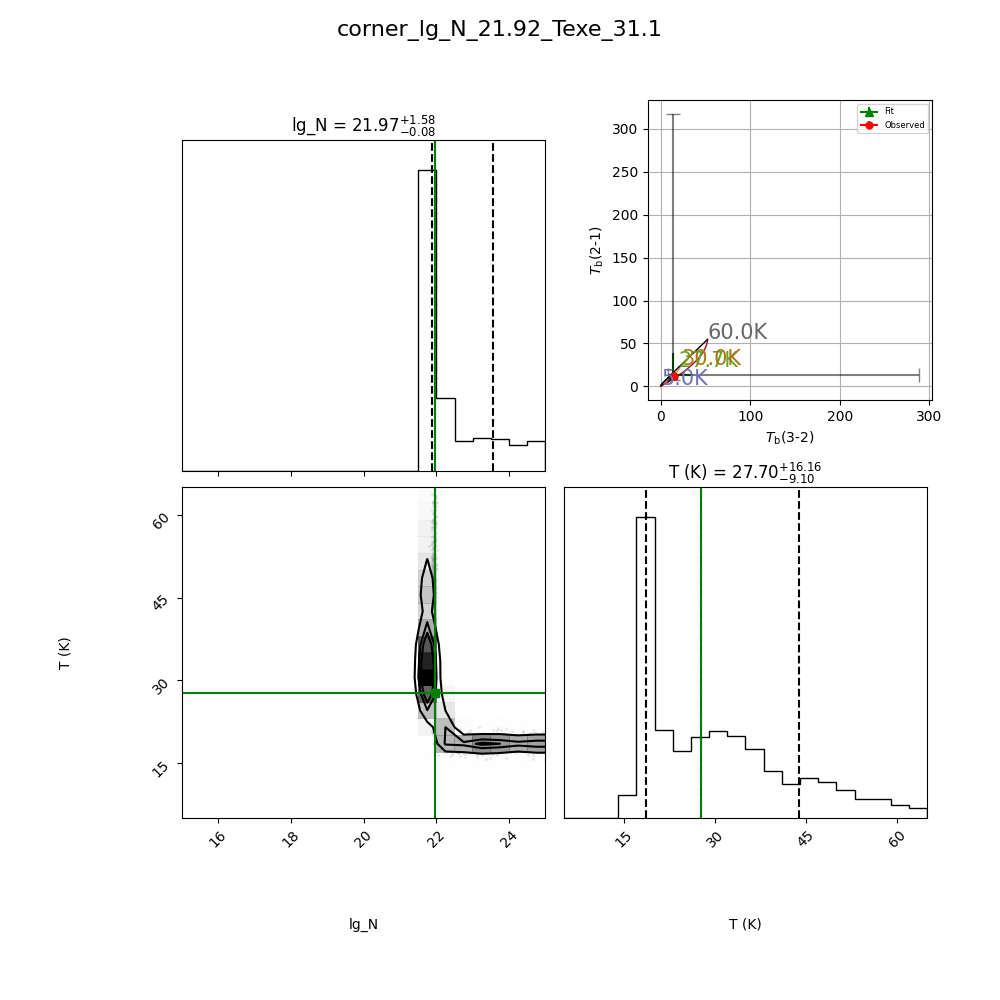

estimating for i = 14 , Tb7 = 0.0, Tb6 = 0.0


100%|██████████| 5000/5000 [00:10<00:00, 470.90it/s]


dtauv_dT =  1.0390863464822842e-09
dtauv_dT =  3.5968848094610497e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.86e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 4.72e+19, lgNc = 1.97e+01
Ncols and lgNcols med 7.22e+17, lgNc = 1.79e+01
Ncols and lgNcols dwn 6.94e+15, lgNc = 1.58e+01
del T -> + 20.45, - 20.60
del N -> + 4.65e+19, - 7.15e+17
[[0.00238874 0.12592752]]
[[0.00161031 0.08668615]]


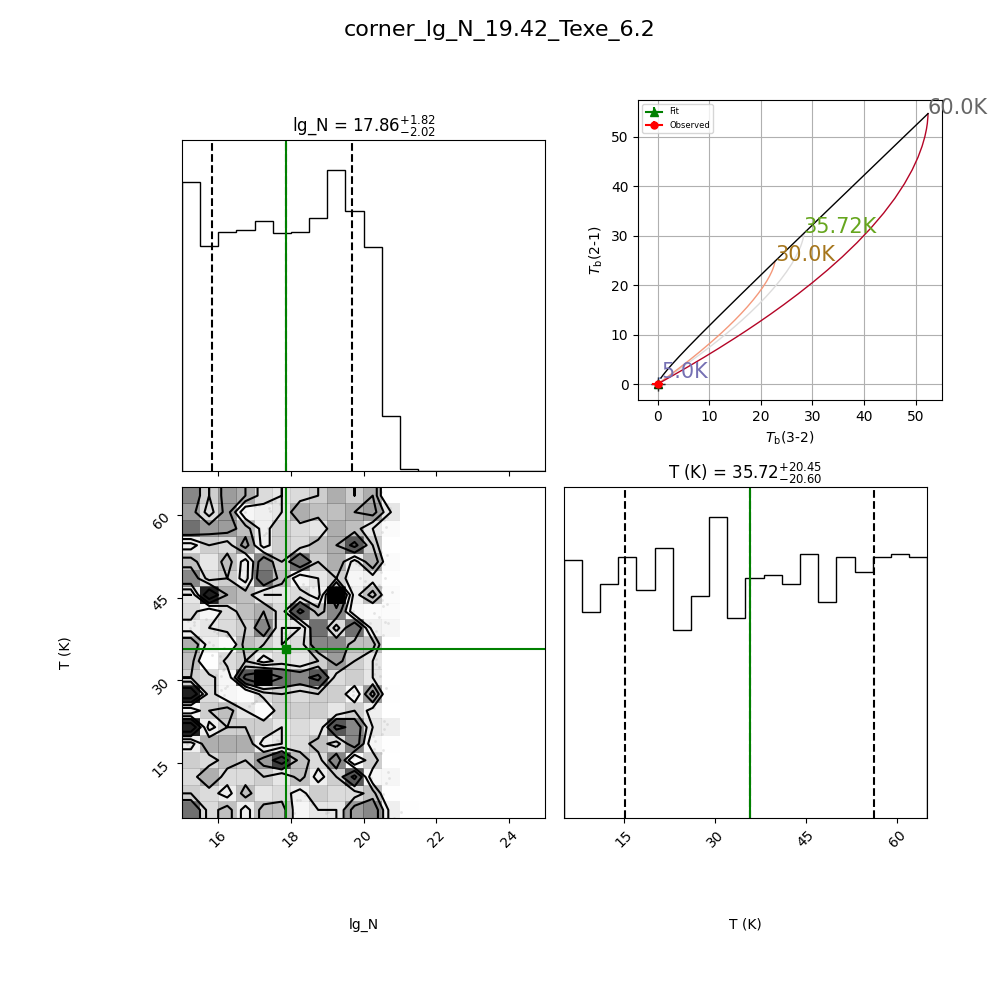

In [80]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

Tb_7_predicts = []
Tb_7_err_predicts = []
Tb_6_predicts = []
Tb_6_err_predicts = []


plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])



ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7, Tb6)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt((0.1*tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*tb6)**2 + 0.49**2), 
                                                estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 5000, burn_in = 1000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)


        Tb_6_predicts.append(Tb_6_prediction[0])
        Tb_6_err_predicts.append(Tb_6_prediction[1])
        
        Tb_7_predicts.append(Tb_7_prediction[0])
        Tb_7_err_predicts.append(Tb_7_prediction[1])


        # fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions                    
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        plt.close()

    ctr = ctr+1


In [81]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 15)


#### Visualize results (Data without noise)

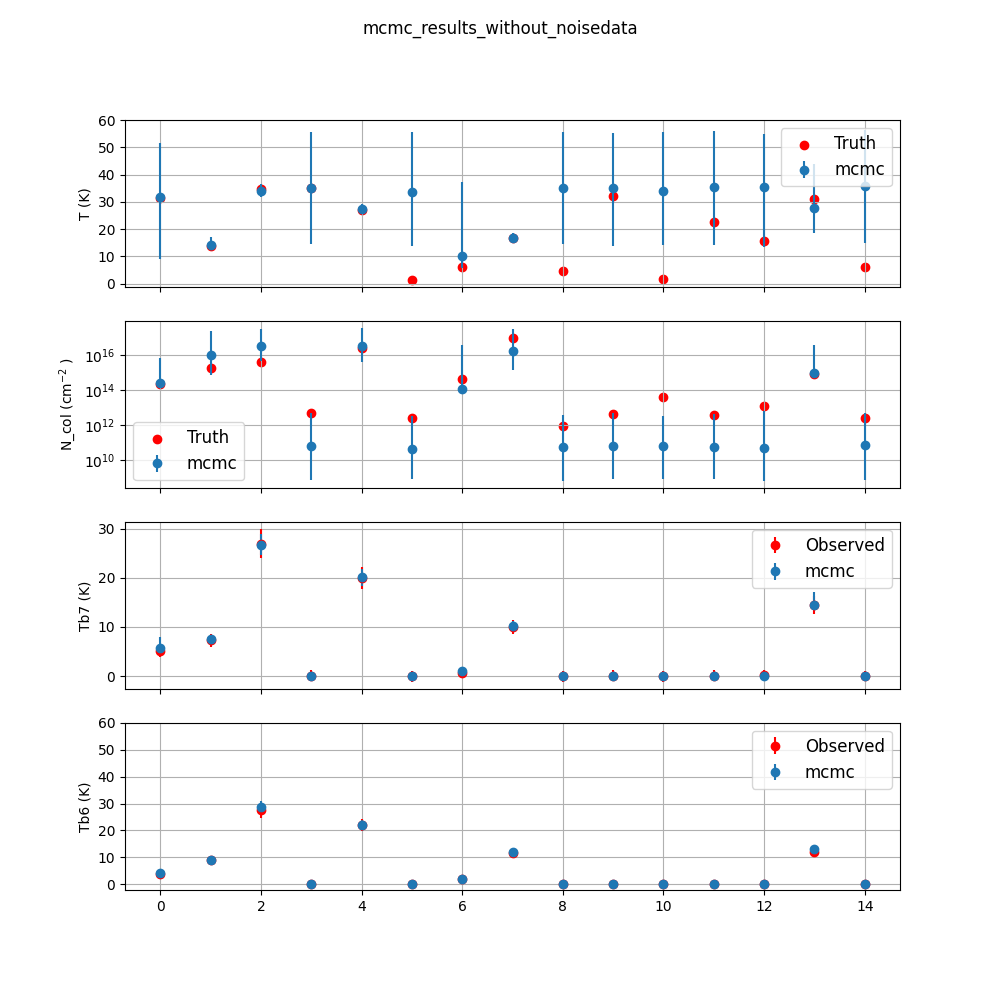

In [83]:
vis_results_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), fmt='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
axes[0].set_ylabel(r"T (K)")
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].errorbar(r, np.array(Ncol_predicted)*N_conv_fraction, yerr=np.array(N_err_predicted)*N_conv_fraction, fmt='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Truth')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})


axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), color = 'r', 
                 label = 'Observed',  fmt='o')
axes[2].errorbar(r, np.array(Tb_7_predicts), yerr=np.array(np.abs(Tb_7_err_predicts)).T, fmt='o', label = 'mcmc')
axes[2].set_ylabel(r"Tb7 (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})


axes[3].errorbar(r, np.array(Tb6), yerr= np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), color = 'r', label = 'Observed', fmt='o')
axes[3].errorbar(r, np.array(Tb_6_predicts), yerr=np.array(np.abs(Tb_6_err_predicts)).T, fmt='o', label = 'mcmc')
axes[3].set_ylabel(r"Tb6 (K)")
axes[3].set_yticks([0,10,20,30,40,50,60])
axes[3].grid(True)
axes[3].legend(prop={'size': 12})

vis_results_fig.suptitle("mcmc_results_without_noisedata")

vis_results_figname =  'mcmc_results_without_noisedata.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')
plt.show()

#### Data visualization (data within fluxcal+rms noise)

lg_N [21.32, 22.26, 22.63, 19.69, 23.42, 19.4, 21.62, 23.97, 18.93, 19.63, 20.58, 19.56, 20.07, 21.92, 19.42]
lg T [31.42, 13.9, 34.69, 34.93, 27.07, 1.42, 6.29, 16.7, 4.85, 32.0, 1.77, 22.69, 15.54, 31.14, 6.19]


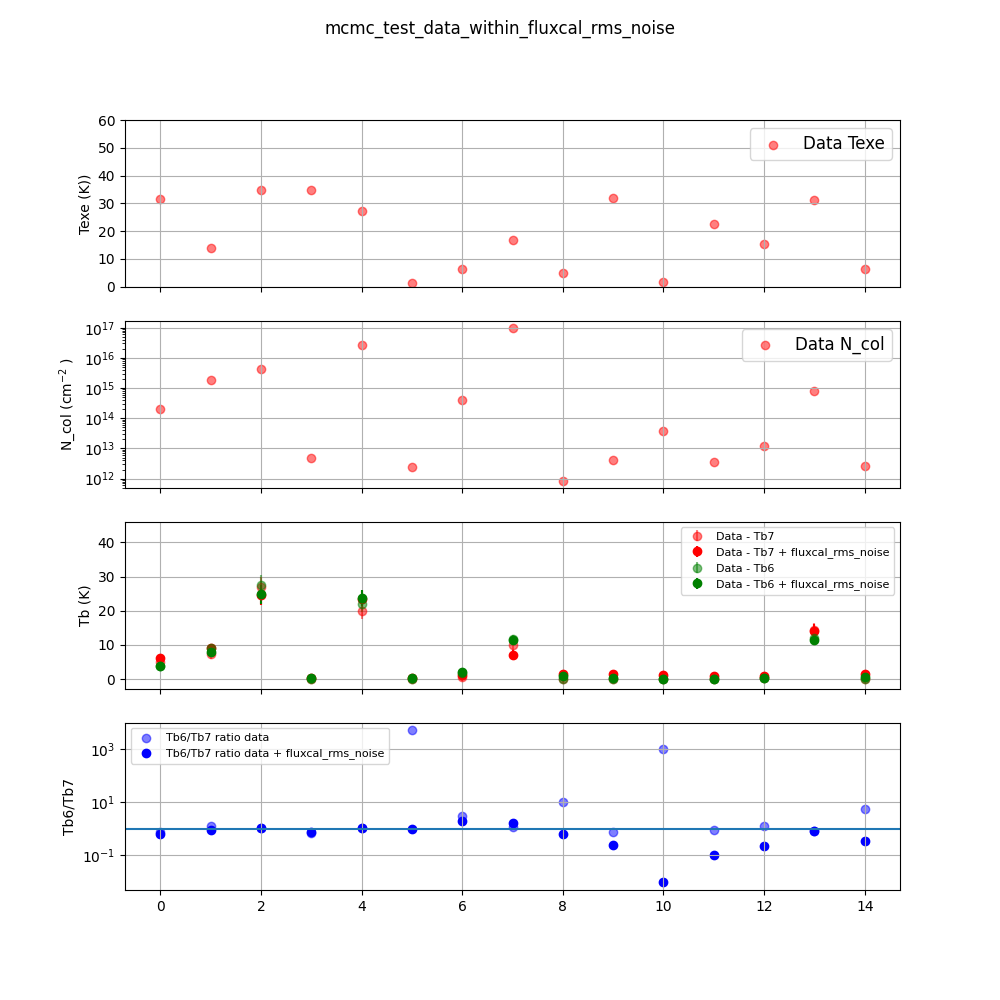

In [61]:
op_dir_label = "mcmc_estimator_test_data_within_fluxcal_rms_noise"
print("lg_N",[round(n,2) for n in lg_N])
print("lg T",[round(t,2) for t in Texe])


vis_data_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

N_conv_fraction = 1.e-7
r = np.arange(len(Tb7))


axes[0].scatter(r, Texe, marker='o', color = 'r', label = 'Data Texe',  alpha = 0.5)
axes[0].set_ylabel(r"Texe (K))")
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Data N_col', alpha = 0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yticks([1.e9,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16, 1.e17])
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[2].errorbar(r, Tb7, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7', fmt='o', color='r', alpha = 0.5)
axes[2].errorbar(r, Tb7_with_rand_error, yerr=np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), 
                 label = 'Data - Tb7 + fluxcal_rms_noise', color='r', fmt='o')
axes[2].errorbar(r, Tb6, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6', fmt='o', color='g',alpha = 0.5)
axes[2].errorbar(r, Tb6_with_rand_error, yerr=np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), 
                 label = 'Data - Tb6 + fluxcal_rms_noise', color='g', fmt='o')
axes[2].set_yticks([0,10,20,30,40])
axes[2].set_ylim([-2.9,46])
axes[2].set_ylabel(r"Tb (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 8})

axes[3].scatter(r, np.array(Tb6)/np.array(Tb7), marker='o', label = 'Tb6/Tb7 ratio data', color='blue', alpha = 0.5)
axes[3].scatter(r, np.array(Tb6_with_rand_error)/np.array(Tb7_with_rand_error), marker='o', 
                label = 'Tb6/Tb7 ratio data + fluxcal_rms_noise', color='blue')
axes[3].axhline(y=1)
axes[3].set_ylabel(r"Tb6/Tb7")
axes[3].set_yscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 8})


vis_data_fig.suptitle("mcmc_test_data_within_fluxcal_rms_noise")

vis_results_figname =  'mcmc_test_data_within_fluxcal_rms_noise.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_data_figpath = os.path.join(dir_path, vis_results_figname)
vis_data_fig.savefig(fname = vis_data_figpath, dpi=300, format='jpeg')



#### T estimation loop (data with noise within fluxcal+rms noise)

In [46]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

In [47]:
Texe_predicted = []
Texe_upq_predicted = []
Texe_lq_predicted = []

Ncol_predicted = []
Ncol_upq_predicted = []
Ncol_lq_predicted = []

Tb_7_predicts = []
Tb_7_err_predicts = []
Tb_6_predicts = []
Tb_6_err_predicts = []


plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])



ctr = 0

for i, (tb7, tb6) in enumerate(zip(Tb7_with_rand_error, Tb6_with_rand_error)):

    print(f"estimating for i = {i} , Tb7 = {tb7:.1f}, Tb6 = {tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = tb7, t2=tb6, 
                                                    s1=np.sqrt((0.1*tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*tb6)**2 + 0.49**2), 
                                                estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 5000, burn_in = 1000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(i,3)), str(round(i,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_predicted.append(T_qtls[0])
    Texe_predicted.append(T_qtls[1])
    Texe_upq_predicted.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_predicted.append(Ncol_qtls[0])
    Ncol_predicted.append(Ncol_qtls[1])
    Ncol_upq_predicted.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=tb7, tb6=tb6, figure = fig1,
                                axes = ax)


        Tb_6_predicts.append(Tb_6_prediction[0])
        Tb_6_err_predicts.append(Tb_6_prediction[1])
        
        Tb_7_predicts.append(Tb_7_prediction[0])
        Tb_7_err_predicts.append(Tb_7_prediction[1])


        # fig_lt, ax_lt, Tb_7_predictions, Tb_6_predictions                    
        fig1.suptitle('corner_lg_N_'+str(round(lg_N[i],2))+'_Texe_'+str(round(Texe[i],1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(i,2))+'_v_'+str(round(i,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        plt.close()

    ctr = ctr+1


estimating for i = 0 , Tb7 = 6.3, Tb6 = 4.0


100%|██████████| 5000/5000 [00:12<00:00, 402.24it/s]


dtauv_dT =  1.8160634143523364e-06
dtauv_dT =  5.923124056024927e-07
Tb7_dIv_dN = 2.15e-14, Tb6_dIv_dN = 1.52e-14
Tb7_dIv_dT = 0.19, Tb6_dIv_dT = 0.12
Ncols and lgNcols up 3.41e+21, lgNc = 2.15e+01
Ncols and lgNcols med 2.65e+21, lgNc = 2.14e+01
Ncols and lgNcols dwn 2.20e+21, lgNc = 2.13e+01
del T -> + 15.36, - 21.10
del N -> + 7.63e+20, - 4.52e+20
[[4.0253214 3.2836873]]
[[2.58671805 2.15256174]]
estimating for i = 1 , Tb7 = 9.0, Tb6 = 8.1


100%|██████████| 5000/5000 [00:12<00:00, 413.32it/s]


dtauv_dT =  0.0001591962493280756
dtauv_dT =  8.118076654728111e-05
Tb7_dIv_dN = 7.74e-15, Tb6_dIv_dN = 8.94e-15
Tb7_dIv_dT = 0.63, Tb6_dIv_dT = 0.60
Ncols and lgNcols up 5.61e+23, lgNc = 2.37e+01
Ncols and lgNcols med 5.77e+21, lgNc = 2.18e+01
Ncols and lgNcols dwn 4.42e+21, lgNc = 2.16e+01
del T -> + 16.74, - 5.57
del N -> + 5.55e+23, - 1.35e+21
[[  3.6324235  429.89833763]]
[[  3.53330041 496.34138477]]
estimating for i = 2 , Tb7 = 24.6, Tb6 = 24.8


100%|██████████| 5000/5000 [00:13<00:00, 360.60it/s]


dtauv_dT =  0.0008393042056504
dtauv_dT =  0.0003088290359377877
Tb7_dIv_dN = 2.95e-29, Tb6_dIv_dN = 1.70e-24
Tb7_dIv_dT = 0.98, Tb6_dIv_dT = 0.99
Ncols and lgNcols up 3.43e+24, lgNc = 2.45e+01
Ncols and lgNcols med 3.06e+23, lgNc = 2.35e+01
Ncols and lgNcols dwn 3.15e+22, lgNc = 2.25e+01
del T -> + 2.63, - 2.10
del N -> + 3.12e+24, - 2.74e+23
[[2.05657678 2.577479  ]]
[[2.08078971 2.60782472]]
estimating for i = 3 , Tb7 = 0.3, Tb6 = 0.3


100%|██████████| 5000/5000 [00:11<00:00, 431.66it/s]


dtauv_dT =  1.5884499905167916e-09
dtauv_dT =  5.543988752577924e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.88e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 8.29e+19, lgNc = 1.99e+01
Ncols and lgNcols med 1.01e+18, lgNc = 1.80e+01
Ncols and lgNcols dwn 8.54e+15, lgNc = 1.59e+01
del T -> + 20.34, - 20.42
del N -> + 8.19e+19, - 9.97e+17
[[0.00335013 0.22208285]]
[[0.0022752  0.15412428]]
estimating for i = 4 , Tb7 = 23.5, Tb6 = 23.8


100%|██████████| 5000/5000 [00:13<00:00, 365.43it/s]


dtauv_dT =  0.001063000695073168
dtauv_dT =  0.00039837064191818505
Tb7_dIv_dN = 6.64e-31, Tb6_dIv_dN = 9.20e-26
Tb7_dIv_dT = 0.98, Tb6_dIv_dT = 0.99
Ncols and lgNcols up 3.39e+24, lgNc = 2.45e+01
Ncols and lgNcols med 3.25e+23, lgNc = 2.35e+01
Ncols and lgNcols dwn 3.30e+22, lgNc = 2.25e+01
del T -> + 2.53, - 1.93
del N -> + 3.07e+24, - 2.92e+23
[[1.88803346 2.47261629]]
[[1.91191348 2.50389017]]
estimating for i = 5 , Tb7 = 0.5, Tb6 = 0.5


100%|██████████| 5000/5000 [00:11<00:00, 432.83it/s]


dtauv_dT =  1.8298187655294367e-09
dtauv_dT =  6.482604419951815e-10
Tb7_dIv_dN = 2.72e-14, Tb6_dIv_dN = 1.91e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 1.32e+20, lgNc = 2.01e+01
Ncols and lgNcols med 9.83e+17, lgNc = 1.80e+01
Ncols and lgNcols dwn 9.19e+15, lgNc = 1.60e+01
del T -> + 21.86, - 19.80
del N -> + 1.31e+20, - 9.74e+17
[[0.00328877 0.35497396]]
[[0.00226461 0.25000594]]
estimating for i = 6 , Tb7 = 1.1, Tb6 = 2.1


100%|██████████| 5000/5000 [00:12<00:00, 414.20it/s]


dtauv_dT =  0.0002506549786396741
dtauv_dT =  0.00022521224693315296
Tb7_dIv_dN = 8.77e-15, Tb6_dIv_dN = 1.38e-14
Tb7_dIv_dT = 0.23, Tb6_dIv_dT = 0.32
Ncols and lgNcols up 2.79e+23, lgNc = 2.34e+01
Ncols and lgNcols med 1.33e+21, lgNc = 2.11e+01
Ncols and lgNcols dwn 7.53e+20, lgNc = 2.09e+01
del T -> + 25.19, - 5.24
del N -> + 2.78e+23, - 5.75e+20
[[  1.29044864 243.84472506]]
[[  1.85292221 382.52354888]]
estimating for i = 7 , Tb7 = 7.0, Tb6 = 11.5


100%|██████████| 5000/5000 [00:13<00:00, 364.20it/s]


dtauv_dT =  0.016341803518361776
dtauv_dT =  0.010282626326668147
Tb7_dIv_dN = 8.00e-37, Tb6_dIv_dN = 1.88e-37
Tb7_dIv_dT = 0.91, Tb6_dIv_dT = 0.96
Ncols and lgNcols up 3.27e+24, lgNc = 2.45e+01
Ncols and lgNcols med 2.38e+23, lgNc = 2.34e+01
Ncols and lgNcols dwn 1.72e+22, lgNc = 2.22e+01
del T -> + 1.11, - 1.03
del N -> + 3.04e+24, - 2.21e+23
[[0.93974792 1.01531685]]
[[0.98737851 1.06677761]]
estimating for i = 8 , Tb7 = 1.5, Tb6 = 0.9


100%|██████████| 5000/5000 [00:11<00:00, 429.17it/s]


dtauv_dT =  2.807782516902728e-07
dtauv_dT =  9.718491174484898e-08
Tb7_dIv_dN = 2.66e-14, Tb6_dIv_dN = 1.84e-14
Tb7_dIv_dT = 0.02, Tb6_dIv_dT = 0.01
Ncols and lgNcols up 6.58e+20, lgNc = 2.08e+01
Ncols and lgNcols med 1.95e+20, lgNc = 2.03e+01
Ncols and lgNcols dwn 6.56e+16, lgNc = 1.68e+01
del T -> + 19.87, - 20.83
del N -> + 4.62e+20, - 1.95e+20
[[0.64259123 1.28064196]]
[[0.43545705 0.88296566]]
estimating for i = 9 , Tb7 = 1.6, Tb6 = 0.4


100%|██████████| 5000/5000 [00:11<00:00, 427.96it/s]


dtauv_dT =  5.208552166037185e-09
dtauv_dT =  1.7967006821087573e-09
Tb7_dIv_dN = 2.70e-14, Tb6_dIv_dN = 1.86e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 2.52e+20, lgNc = 2.04e+01
Ncols and lgNcols med 3.77e+18, lgNc = 1.86e+01
Ncols and lgNcols dwn 1.69e+16, lgNc = 1.62e+01
del T -> + 20.37, - 21.49
del N -> + 2.48e+20, - 3.75e+18
[[0.01263896 0.67080862]]
[[0.00848625 0.46023439]]
estimating for i = 10 , Tb7 = 1.3, Tb6 = 0.0


100%|██████████| 5000/5000 [00:12<00:00, 398.94it/s]


dtauv_dT =  9.573944713257643e-10
dtauv_dT =  3.306321861376747e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.86e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 6.51e+19, lgNc = 1.98e+01
Ncols and lgNcols med 6.84e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 6.20e+15, lgNc = 1.58e+01
del T -> + 20.13, - 20.71
del N -> + 6.44e+19, - 6.77e+17
[[0.00226024 0.17443059]]
[[0.00152037 0.11979732]]
estimating for i = 11 , Tb7 = 1.0, Tb6 = 0.1


100%|██████████| 5000/5000 [00:12<00:00, 405.36it/s]


dtauv_dT =  9.911464139898643e-10
dtauv_dT =  3.432592478797064e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.87e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 6.87e+19, lgNc = 1.98e+01
Ncols and lgNcols med 6.85e+17, lgNc = 1.78e+01
Ncols and lgNcols dwn 6.41e+15, lgNc = 1.58e+01
del T -> + 20.58, - 21.25
del N -> + 6.80e+19, - 6.79e+17
[[0.00229276 0.18426824]]
[[0.00154488 0.12690749]]
estimating for i = 12 , Tb7 = 1.1, Tb6 = 0.2


100%|██████████| 5000/5000 [00:11<00:00, 423.83it/s]


dtauv_dT =  1.3413450974631653e-09
dtauv_dT =  4.6393661612828725e-10
Tb7_dIv_dN = 2.71e-14, Tb6_dIv_dN = 1.86e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 9.62e+19, lgNc = 2.00e+01
Ncols and lgNcols med 9.41e+17, lgNc = 1.80e+01
Ncols and lgNcols dwn 8.15e+15, lgNc = 1.59e+01
del T -> + 20.30, - 20.95
del N -> + 9.53e+19, - 9.33e+17
[[0.00313023 0.25788481]]
[[0.00210772 0.17738154]]
estimating for i = 13 , Tb7 = 14.2, Tb6 = 11.6


100%|██████████| 5000/5000 [00:13<00:00, 377.35it/s]


dtauv_dT =  2.5069379023772285e-05
dtauv_dT =  9.310655065431536e-06
Tb7_dIv_dN = 1.04e-14, Tb6_dIv_dN = 1.04e-14
Tb7_dIv_dT = 0.60, Tb6_dIv_dT = 0.47
Ncols and lgNcols up 1.06e+23, lgNc = 2.30e+01
Ncols and lgNcols med 8.34e+21, lgNc = 2.19e+01
Ncols and lgNcols dwn 7.13e+21, lgNc = 2.19e+01
del T -> + 15.25, - 12.20
del N -> + 9.72e+22, - 1.21e+21
[[  7.4822799  101.26690978]]
[[  5.92387069 101.69329951]]
estimating for i = 14 , Tb7 = 1.5, Tb6 = 0.5


100%|██████████| 5000/5000 [00:11<00:00, 424.89it/s]


dtauv_dT =  1.1731897276175586e-08
dtauv_dT =  4.0001451710941936e-09
Tb7_dIv_dN = 2.70e-14, Tb6_dIv_dN = 1.83e-14
Tb7_dIv_dT = 0.00, Tb6_dIv_dT = 0.00
Ncols and lgNcols up 3.23e+20, lgNc = 2.05e+01
Ncols and lgNcols med 9.73e+18, lgNc = 1.90e+01
Ncols and lgNcols dwn 1.89e+16, lgNc = 1.63e+01
del T -> + 19.33, - 21.32
del N -> + 3.14e+20, - 9.71e+18
[[0.03212816 0.84528236]]
[[0.02136542 0.57343352]]


In [48]:
# Calculate errorbars

T_err_predicted = [np.array(Texe_predicted)-np.array(Texe_lq_predicted),np.array(Texe_upq_predicted)-np.array(Texe_predicted)] #[tl,tu] for tl,tu in zip(

N_err_predicted = [np.array(Ncol_predicted)-np.array(Ncol_lq_predicted), np.array(Ncol_upq_predicted)-np.array(Ncol_predicted)]

print(np.shape(T_err_predicted))

(2, 15)


#### Visualize results (Data without noise)

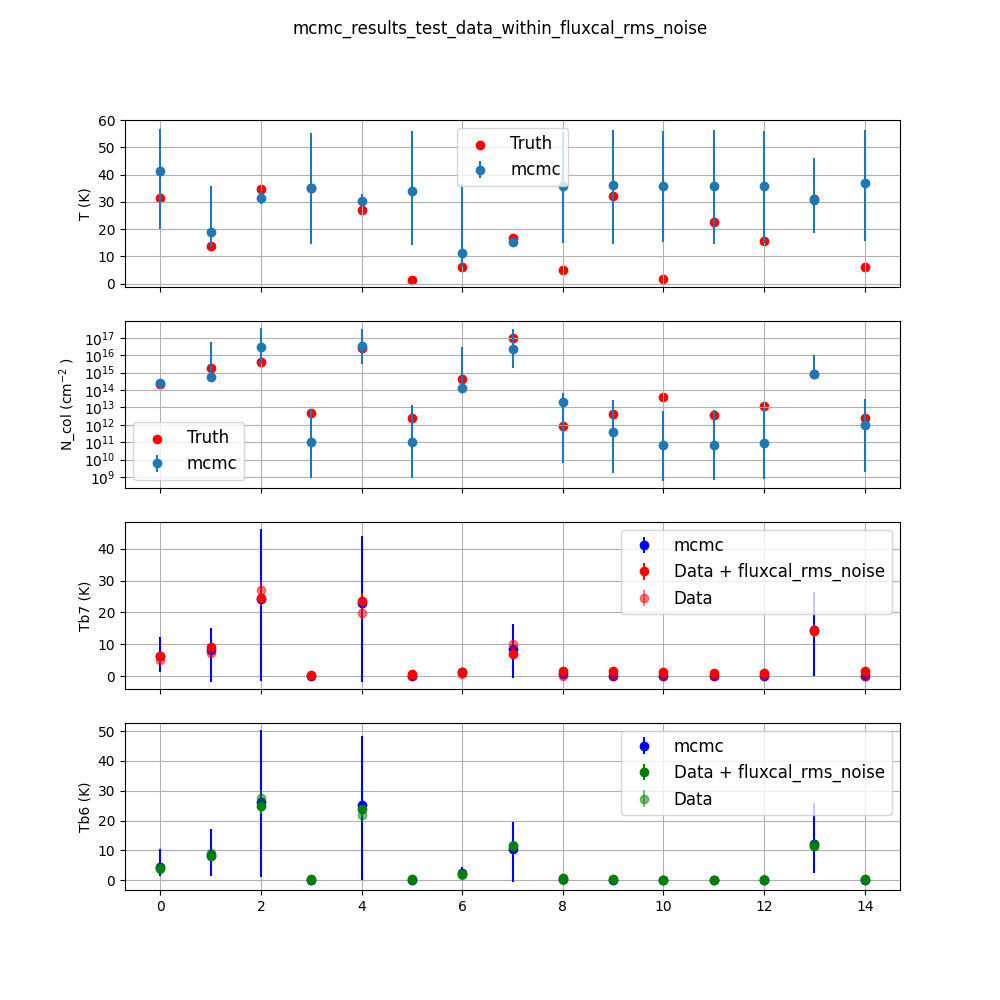

In [55]:
vis_results_fig, axes = plt.subplots(4, figsize=(10, 10), sharex=True)

r = np.arange(len(Texe_predicted))
axes[0].errorbar(r, Texe_predicted, yerr=np.array(T_err_predicted), fmt='o', label = 'mcmc')
axes[0].scatter(r, Texe, marker='o',  color = 'r', label = 'Truth')
axes[0].set_ylabel(r"T (K)")
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].grid(True)
axes[0].legend(prop={'size': 12})

axes[1].errorbar(r, np.array(Ncol_predicted)*N_conv_fraction, yerr=np.array(N_err_predicted)*N_conv_fraction, fmt='o', label = 'mcmc')
axes[1].scatter(r, 10**np.array(lg_N)*N_conv_fraction, marker='o', color = 'r', label = 'Truth')
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_yscale('log')
axes[1].set_yticks([1.e9,1.e10,1.e11,1.e12,1.e13,1.e14,1.e15,1.e16, 1.e17])
axes[1].grid(True)
axes[1].legend(prop={'size': 12})

axes[2].errorbar(r, np.array(Tb_7_predicts), yerr=np.array(Tb_7_err_predicts).T, fmt='o', label = 'mcmc',
                  color = 'blue')
axes[2].errorbar(r, np.array(Tb7_with_rand_error), yerr= np.sqrt((0.1*np.array(Tb7_with_rand_error))**2 + 1.08**2), color = 'r', 
                 label = 'Data + fluxcal_rms_noise',  fmt='o')
axes[2].errorbar(r, np.array(Tb7), yerr= np.sqrt((0.1*np.array(Tb7))**2 + 1.08**2), color = 'r', 
                 label = 'Data',  fmt='o', alpha = 0.5)
axes[2].set_ylabel(r"Tb7 (K)")
axes[2].grid(True)
axes[2].legend(prop={'size': 12})

axes[3].errorbar(r, np.array(Tb_6_predicts), yerr=np.array(Tb_6_err_predicts).T, fmt='o', label = 'mcmc', color = 'b')
axes[3].errorbar(r, np.array(Tb6_with_rand_error), yerr= np.sqrt((0.1*np.array(Tb6_with_rand_error))**2 + 0.49**2), color = 'g', 
                 label = 'Data + fluxcal_rms_noise',  fmt='o')
axes[3].errorbar(r, np.array(Tb6), yerr= np.sqrt((0.1*np.array(Tb6))**2 + 0.49**2), color = 'g', label = 'Data', 
                 fmt='o', alpha = 0.5)
axes[3].set_ylabel(r"Tb6 (K)")
axes[3].grid(True)
axes[3].legend(prop={'size': 12})

vis_results_fig.suptitle("mcmc_results_test_data_within_fluxcal_rms_noise")

vis_results_figname =  'mcmc_results_test_data_within_fluxcal_rms_noise.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')
plt.show()